In [4]:
import pickle
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
from transformers import GPT2Tokenizer, GPT2Config
from LLMHeadModelWithFFNOutput import LLMHeadModelWithFFNOutput
from matplotlib import pyplot as plt
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
import copy

In [5]:
# Configuración del modelo y el tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
config = GPT2Config.from_pretrained('gpt2')
num_layers = config.n_layer
num_neurons = config.hidden_size * 4
max_length = 19
index_number = -3
test_file = os.path.join('datasets', 'test_dataset.txt')
folder = os.path.join('experiments', "activations")
file = os.path.join(folder, "gpt2.pickle")
model = LLMHeadModelWithFFNOutput.from_pretrained('gpt2-finetuned', config=config)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Device:", device)

Device: cuda


In [6]:
with open(test_file, encoding="utf-8") as file:
    text = file.readlines()

prompts = [t[:index_number].strip() for t in text]
numbers = [t[index_number:].strip() for t in text]

In [7]:
def get_accuracy(model, prompts: list, numbers: list, get_activations: bool = False) -> float:
    accuracy = 0
    activations = []
    initial_shape = None
    for prompt, number in zip(prompts, numbers):
        input_ids = torch.tensor([tokenizer.encode(prompt)]).to(device)
        outputs_tokens = model.generate(input_ids, max_length=max_length, pad_token_id=tokenizer.eos_token_id)
        output_text = tokenizer.decode(outputs_tokens[0], skip_special_tokens=True)

        output_text = output_text[index_number:].strip()

        if output_text == number:
            accuracy += 1

        if get_activations:
            
            if initial_shape is None:
                initial_shape = activation_ffn.shape

            activation_ffn = model.get_activation_ffn()
            if activation_ffn.shape == initial_shape:
                activations.append(activation_ffn)

    return accuracy * 100 / len(prompts), activations

def get_activation_ffn(model, prompts: list) -> list:
    activations = []
    for prompt in tqdm(prompts, desc="Getting activations..."):
        input_ids = torch.tensor([tokenizer.encode(prompt)]).to(device)
        _ = model.generate(input_ids, max_length=max_length, pad_token_id=tokenizer.eos_token_id)
        activation_ffn = model.get_activation_ffn()
        activations.append(activation_ffn)

    activation_ffn_array = activations

    return activation_ffn_array

In [8]:
acc, activations = get_accuracy(model, prompts, numbers)
print("Accuracy:", acc)

c:\code\ExAI\exai\lib\site-packages\transformers\generation\utils.py:1363: UserWarning: Input length of input_ids is 19, but `max_length` is set to 19. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Accuracy: 25.4


In [9]:
activation_ffn_array = np.stack(activations)

ValueError: need at least one array to stack

In [75]:
print(activation_ffn_array.shape)

(714, 12, 1, 1, 3072)


In [76]:
# reshape
activation_ffn_array = activation_ffn_array.reshape(num_layers, -1, num_neurons)
print(activation_ffn_array.shape)

(12, 714, 3072)


In [77]:
# save
with open("gpt2.pickle", 'wb') as f:
    pickle.dump(activation_ffn_array, f)

## Prunning

In [78]:
def get_high_activations_neuron_per_layer(activations: np.array, layer: int, threshold: float = 0.3, n_components: int = 10) -> tuple:
    first_layer_activations = activations[layer]
    
    scaler = MinMaxScaler()
    normalized_activations = scaler.fit_transform(first_layer_activations.reshape(-1, first_layer_activations.shape[-1])).reshape(first_layer_activations.shape)

    nmf = NMF(n_components=n_components, max_iter=1000, random_state=0)
    w = nmf.fit_transform(normalized_activations.reshape(-1, normalized_activations.shape[-1]))  # Aplana las activaciones para NMF
    h = nmf.components_
    
    low_contribution_neurons = np.where(h.mean(axis=0) > threshold)[0]

    return low_contribution_neurons, w, h

class Conv1D(nn.Module):
    """
    1D-convolutional layer as defined by Radford et al. for OpenAI GPT (and also used in GPT-2).

    Basically works like a linear layer but the weights are transposed.

    Args:
        nf (`int`): The number of output features.
        nx (`int`): The number of input features.
    """

    def __init__(self, nf, nx):
        super().__init__()
        self.nf = nf
        self.weight = nn.Parameter(torch.empty(nx, nf))
        self.bias = nn.Parameter(torch.zeros(nf))
        nn.init.normal_(self.weight, std=0.02)

    def forward(self, x):
        size_out = x.size()[:-1] + (self.nf,)
        x = torch.addmm(self.bias, x.view(-1, x.size(-1)), self.weight)
        x = x.view(size_out)
        return x


def prune_conv1d_layer(layer: Conv1D, index: torch.LongTensor, dim: int = 1) -> Conv1D:
    """
    Prune a Conv1D layer to keep only entries in index. A Conv1D work as a Linear layer (see e.g. BERT) but the weights
    are transposed.

    Used to remove heads.

    Args:
        layer ([`~pytorch_utils.Conv1D`]): The layer to prune.
        index (`torch.LongTensor`): The indices to keep in the layer.
        dim (`int`, *optional*, defaults to 1): The dimension on which to keep the indices.

    Returns:
        [`~pytorch_utils.Conv1D`]: The pruned layer as a new layer with `requires_grad=True`.
    """
    index = index.to(layer.weight.device)
    W = layer.weight.index_select(dim, index).clone().detach()
    if dim == 0:
        b = layer.bias.clone().detach()
    else:
        b = layer.bias[index].clone().detach()
    new_size = list(layer.weight.size())
    new_size[dim] = len(index)
    new_layer = Conv1D(new_size[1], new_size[0]).to(layer.weight.device)
    new_layer.weight.requires_grad = False
    new_layer.weight.copy_(W.contiguous())
    new_layer.weight.requires_grad = True
    new_layer.bias.requires_grad = False
    new_layer.bias.copy_(b.contiguous())
    new_layer.bias.requires_grad = True
    return new_layer


def plot_w_and_h_heatmaps(w: np.array, h: np.array, layer: int):
    # Mapa de calor para W
    plt.figure(figsize=(10, 8))
    sns.heatmap(w, cmap='viridis')
    plt.title('W Heatmap - Layer {}'.format(layer))
    plt.xlabel('Components')
    plt.ylabel('Tokens/Samples')
    plt.show()

    # Mapa de calor para H
    plt.figure(figsize=(10, 8))
    sns.heatmap(h, cmap='viridis')
    plt.title('H Heatmap - Layer {}'.format(layer))
    plt.xlabel('Neurons')
    plt.ylabel('Components')
    plt.show()

In [81]:
print("Number of neurons:", num_neurons)
for i in range(num_layers):
    high_contribution_neurons, w, h = get_high_activations_neuron_per_layer(activation_ffn_array, i, threshold=0.2, n_components=15)
    print("Layer:", i, "Number of pruned neurons:", activation_ffn_array.shape[-1] - len(high_contribution_neurons))
    #plot_w_and_h_heatmaps(w, h, i) 

Number of neurons: 3072
Layer: 0 Number of pruned neurons: 2420
Layer: 1 Number of pruned neurons: 2631
Layer: 2 Number of pruned neurons: 2649
Layer: 3 Number of pruned neurons: 2289
Layer: 4 Number of pruned neurons: 2807
Layer: 5 Number of pruned neurons: 2371
Layer: 6 Number of pruned neurons: 2366
Layer: 7 Number of pruned neurons: 2247
Layer: 8 Number of pruned neurons: 2061
Layer: 9 Number of pruned neurons: 2804
Layer: 10 Number of pruned neurons: 2194
Layer: 11 Number of pruned neurons: 2603


In [102]:
model_copy = copy.deepcopy(model)

In [103]:
high_contribution_neurons_layer_11, w, h = get_high_activations_neuron_per_layer(activation_ffn_array, 11, threshold=0.2, n_components=15)

In [104]:
print(model_copy.transformer.h[11].mlp.c_fc.weight.shape)
print(model_copy.transformer.h[11].mlp.c_proj)
print(model_copy.transformer.h[11].mlp.c_fc.bias.shape)
print(model_copy.transformer.h[11].mlp.c_proj.bias.shape)

torch.Size([768, 3072])
Conv1D()
torch.Size([3072])
torch.Size([768])


In [105]:
# pruning
model_copy.transformer.h[11].mlp.c_fc = prune_conv1d_layer(model_copy.transformer.h[11].mlp.c_fc, torch.LongTensor(high_contribution_neurons_layer_11)) 
print(model_copy.transformer.h[11].mlp.c_fc.weight.shape)
model_copy.transformer.h[11].mlp.c_proj = prune_conv1d_layer(model_copy.transformer.h[11].mlp.c_proj, torch.LongTensor(high_contribution_neurons_layer_11), dim=0)
print(model_copy.transformer.h[11].mlp.c_proj.weight.shape)

torch.Size([768, 469])
torch.Size([469, 768])


In [106]:
acc, _ = get_accuracy(model_copy, prompts, numbers)
print("Accuracy:", acc)

Testing...: 13it [00:00, 30.04it/s]c:\code\ExAI\exai\lib\site-packages\transformers\generation\utils.py:1363: UserWarning: Input length of input_ids is 19, but `max_length` is set to 19. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
Testing...: 1000it [00:21, 47.15it/s]

Accuracy: 29.5


## experiment

In [115]:
print(num_neurons)

3072


In [121]:
accuracis = []
neurons_deleted = []
n_components = 15
layer = 11

for threshold in np.arange(0.1, 1, 0.1):
    high_neurons, W, H = get_high_activations_neuron_per_layer(activation_ffn_array, layer, threshold=threshold, n_components=n_components)
    #print(f'Layer 11: {num_neurons - len(high_neurons)} low contribution neurons')
    if num_neurons - len(high_neurons) > 3070:
        break
    model_copy = copy.deepcopy(model)
    model_copy.transformer.h[layer].mlp.c_fc = prune_conv1d_layer(model_copy.transformer.h[layer].mlp.c_fc, torch.LongTensor(high_neurons)) 
    model_copy.transformer.h[layer].mlp.c_proj = prune_conv1d_layer(model_copy.transformer.h[layer].mlp.c_proj, torch.LongTensor(high_neurons), dim=0)
    acc, _ = get_accuracy(model_copy, prompts, numbers)
    accuracis.append(acc)
    # calculated percentage of neurons deleted
    percentage = (num_neurons - len(high_neurons)) / num_neurons * 100
    neurons_deleted.append(percentage)

c:\code\ExAI\exai\lib\site-packages\transformers\generation\utils.py:1363: UserWarning: Input length of input_ids is 19, but `max_length` is set to 19. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
c:\code\ExAI\exai\lib\site-packages\transformers\generation\utils.py:1363: UserWarning: Input length of input_ids is 19, but `max_length` is set to 19. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
c:\code\ExAI\exai\lib\site-packages\transformers\generation\utils.py:1363: UserWarning: Input length of input_ids is 19, but `max_length` is set to 19. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
c:\code\ExAI\exai\lib\site-packages\transformers\generation\utils.py:1363: UserWarning: Input length of input_ids is 19, but `max_length` is set to 19. This can lead to unexpected behavior. You should consider increasing `max_new_to

In [125]:
accuracis.append(0)
print(accuracis)
neurons_deleted.append(99.9)
print(neurons_deleted)

[29.2, 29.5, 29.5, 29.5, 29.4, 0]
[23.697916666666664, 84.73307291666666, 97.265625, 99.31640625, 99.90234375, 99.9]


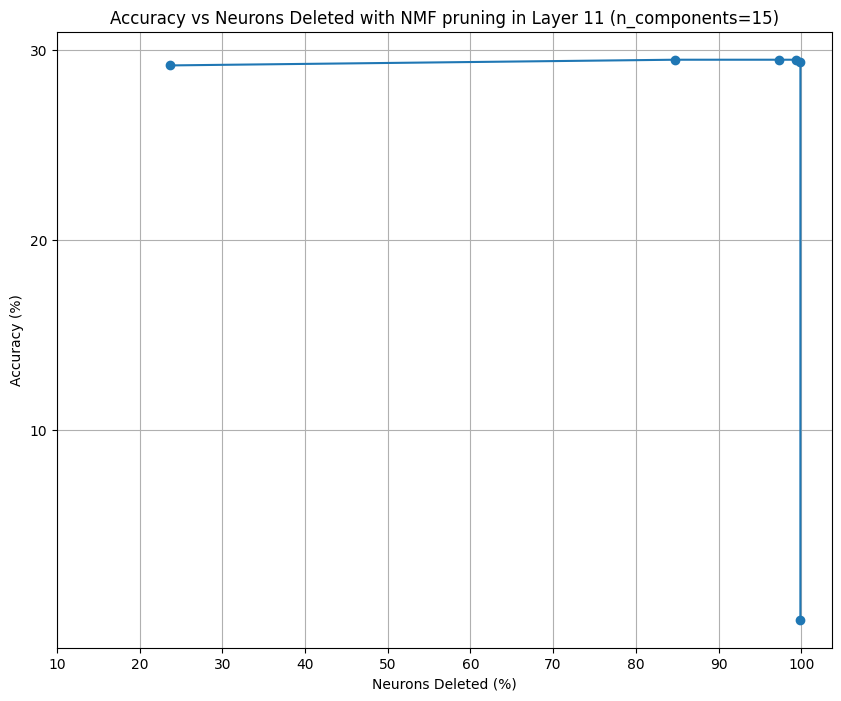

In [126]:
# plot results
plt.figure(figsize=(10, 8))
plt.plot(neurons_deleted, accuracis, 'o-')
plt.title(f'Accuracy vs Neurons Deleted with NMF pruning in Layer 11 (n_components={n_components})')
plt.xlabel('Neurons Deleted (%)')
plt.ylabel('Accuracy (%)')
# grid
plt.grid(True)
# y have to be between 0 and 100 with 10 step
plt.yticks(np.arange(10, 40, 10))
# x have to be between 0 and 100 with 10 step
plt.xticks(np.arange(10, 110, 10))
plt.show()